In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, date
from configparser import SectionProxy
from logging import Logger
import logging

from typing import Mapping, Optional, Dict, List, Tuple

link = 'https://andelenergi.dk/?obexport_format=csv&obexport_start=2022-08-10&obexport_end=2022-08-18&obexport_region=east'

region = 'east'
transport_overhead = 1.59 #DKK

logger = logging.getLogger(__name__)
logger.info('Getting price data')

def _make_El_price_URL(start_date: date, end_date: date, region: str) -> str:
    url = 'https://andelenergi.dk/?obexport_format=csv&obexport_start='+str(start_date)+'&obexport_end='+str(end_date)+'&obexport_region='+region
    return url

def get_El_price(start_date, end_date, region):
    url = _make_El_price_URL(start_date, end_date, region)
    try:
        el_data = pd.read_csv(url, decimal=',')
    except Exception as e:
        logger.exception('Error getting price data from: %s', url)
        return None
    el_data.Date = pd.to_datetime(el_data.Date)#.dt.date
    el_data2 = el_data.set_index('Date')
    el_data2.columns = pd.to_datetime(el_data2.columns)
    el_data2_st = el_data2.stack()
    dates = el_data2_st.index.get_level_values(0) 
    times = el_data2_st.index.get_level_values(1) 
    times.to_pydatetime()

    df = pd.DataFrame(columns= ['Date', 'Time', 'Datetime','Price'])
    df['Date'] = dates.date.astype(str)
    df['Time'] = times.time.astype(str)
    df['Hour'] = times.hour.astype(str)
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' +df['Time'])
    df['Price'] = el_data2_st.values+transport_overhead
    df['Weekday'] = df['Datetime'].dt.day_name()
    df['Weekday'] = df['Weekday'].str.slice(0, 3)
    df['WeekHour'] = df['Weekday']+df['Hour']


    df_future = df[df['Datetime']>str(datetime.now()+timedelta(hours=-8))]
    df_future.reset_index(drop=True,inplace=True)
    return df_future

now = datetime.today()
El_data = get_El_price(now.date()+timedelta(hours=-10), now.date()+timedelta(days=2), region)

print(El_data)

          Date      Time            Datetime  Price Hour Weekday WeekHour
0   2022-08-27  15:00:00 2022-08-27 15:00:00  5.885   15     Sat    Sat15
1   2022-08-27  16:00:00 2022-08-27 16:00:00  6.140   16     Sat    Sat16
2   2022-08-27  17:00:00 2022-08-27 17:00:00  6.749   17     Sat    Sat17
3   2022-08-27  18:00:00 2022-08-27 18:00:00  7.820   18     Sat    Sat18
4   2022-08-27  19:00:00 2022-08-27 19:00:00  8.143   19     Sat    Sat19
5   2022-08-27  20:00:00 2022-08-27 20:00:00  8.100   20     Sat    Sat20
6   2022-08-27  21:00:00 2022-08-27 21:00:00  7.784   21     Sat    Sat21
7   2022-08-27  22:00:00 2022-08-27 22:00:00  7.727   22     Sat    Sat22
8   2022-08-27  23:00:00 2022-08-27 23:00:00  6.951   23     Sat    Sat23
9   2022-08-28  00:00:00 2022-08-28 00:00:00  7.029    0     Sun     Sun0
10  2022-08-28  01:00:00 2022-08-28 01:00:00  6.159    1     Sun     Sun1
11  2022-08-28  02:00:00 2022-08-28 02:00:00  5.939    2     Sun     Sun2
12  2022-08-28  03:00:00 2022-08-28 03

[9]


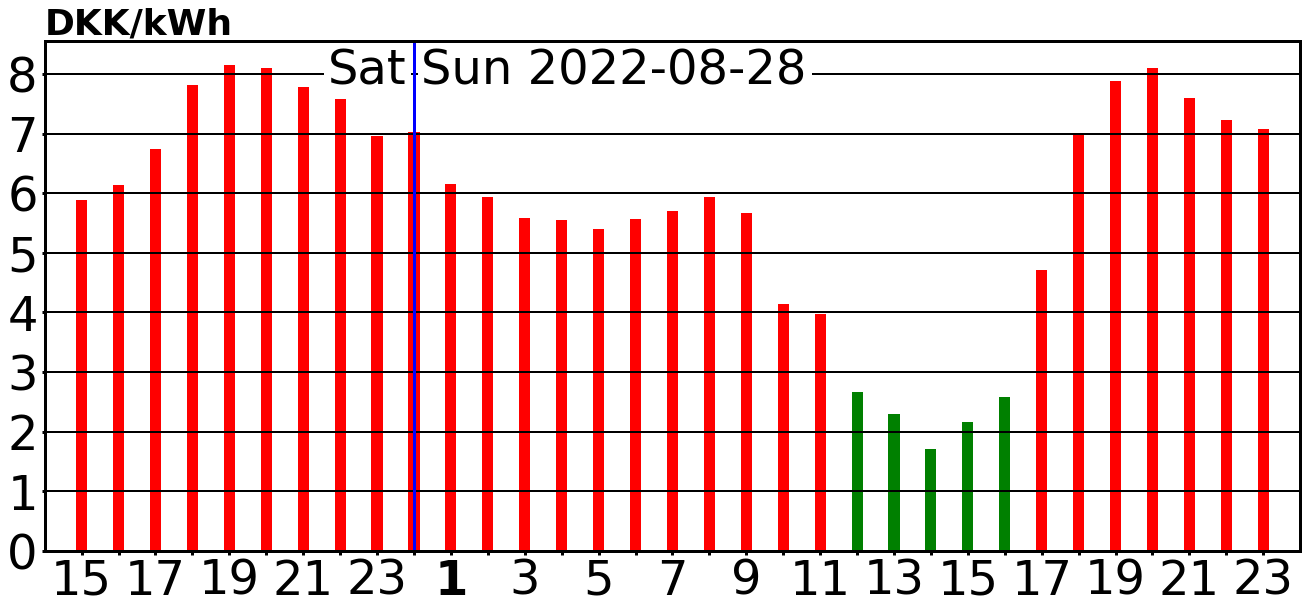

In [39]:
%matplotlib inline
import io
from PIL import Image
import utils
import configparser

CONFIG_FILENAME = 'config.ini'

with open(CONFIG_FILENAME) as f:
    config_parser = configparser.ConfigParser()
    config_parser.read_file(f)
    logger.info('Config: %s', config_parser.items('general'))
    config = config_parser['general']
    fonts = utils.get_fonts(config)

panel_size = (600, 250)

vsize = panel_size[1]
hsize = panel_size[0]
dpi = 80
factor = 3
fig = plt.figure(figsize=((hsize/dpi*factor,vsize/dpi*factor)), frameon=False)
ax = plt.subplot()
font = 'DejaVu Sans'
vals = El_data.Price
hours = El_data.WeekHour
colors = ["green" if i < 3 else "red" for i in vals]
barplot = ax.bar(El_data.WeekHour, El_data.Price, 0.3, color=colors)
ax.set_xlim([-1, len(vals)])
ax.set_xticks(hours)
ax.set_xticklabels(El_data.Hour)
ax.grid(axis='y', linewidth=2, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3)

for i, tick in enumerate(ax.get_xticklabels()):
    tick.set_fontname(font)
    tick.set_fontsize(16*factor)
    if tick.get_text() == '0' or tick.get_text() == '1':
        tick.set_fontweight(weight="bold")
for tick in ax.get_xticklabels()[1::2]:
    tick.set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_fontname(font)
    tick.set_fontsize(16*factor)

if '0' in El_data.Hour.values:
    ind = El_data.index[El_data['Hour'] == '0'].tolist()
    if len(ind)>0: 
        ind1 = ind[0]
        print(ind)
        y_pos = ax.get_ylim()[1]-0.1
        ax.axvline(x = ind1, color = 'b', linewidth = 3, label = 'axvline - full height')
        if ind1>0:
            t = ax.text(float(ind1)-0.2, 
                    y_pos,
                    El_data.Weekday.iloc[ind1-1], 
                    horizontalalignment='right', 
                    verticalalignment='top',
                    fontname=font,
                    fontsize = 16*factor)
            t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
        t = ax.text(float(ind1)+0.2, 
                y_pos, 
                El_data.Weekday.iloc[ind1]+' '+El_data.Date.iloc[ind1], 
                horizontalalignment='left', 
                verticalalignment='top',
                fontname=font,
                fontsize = 16*factor)
        t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
    tit = plt.title('DKK/kWh', fontsize = 12*factor, loc='left')
    tit.set_fontweight(weight="bold")
    
        #plt.show()
plt.show()



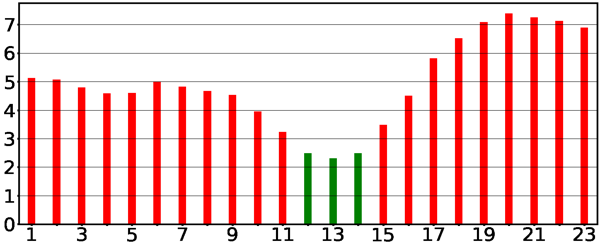

In [118]:
buf = io.BytesIO()

fig.savefig(buf, format="png", dpi=dpi,bbox_inches='tight')
fig.savefig('elpanel_plot.png', format="png", dpi=dpi)
buf.seek(0)
plot_image = Image.open(buf).convert("RGB")
newsize = (hsize, vsize)
im1 = plot_image.resize(newsize)
display(im1)
buf.close()

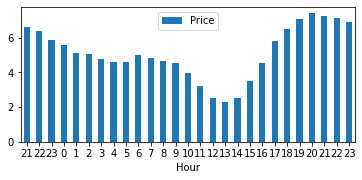

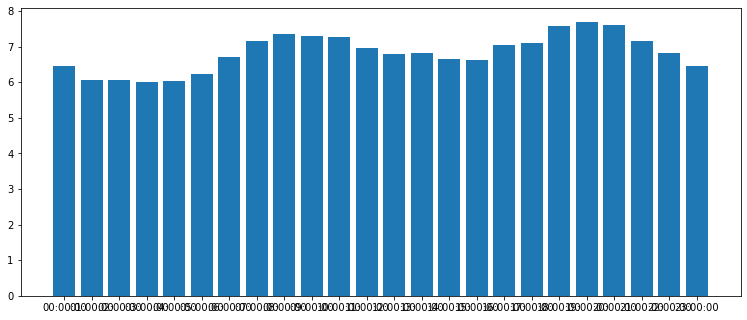

In [196]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_axes([0,0,1,1])
ax.bar(df_future.Time,df_future.Price)
plt.show()